# NER and Classification with LLMs

The exercise demonstrates how to leverage Large Language Models for NER and text classification tasks, comparing their performance with traditional approaches.

Imports

In [40]:
from datasets import load_dataset
import spacy
import subprocess
import pandas as pd
from sklearn.metrics import precision_recall_fscore_support
from tqdm.notebook import tqdm
tqdm.pandas()
import matplotlib.pyplot as plt
import ast
import re
import numpy as np

## Tasks

Objectives (8 points):

1. Install and configure [OLLama](https://ollama.com/) with an appropriate LLM model (e.g. models from: Llama, Mistral, Bielik, Phi families). Rather not use models above 10B paramters.
Sample LLM run command, when OLLama is installed: `ollama run phi3:3.8b`

In [2]:
def test_ollama():
    try:
        result = subprocess.run(["ollama", "--version"], text=True, capture_output=True, check=True)
        return result.stdout.strip()
    except FileNotFoundError:
        return "OLLama nie jest zainstalowany lub nie jest dostępny w PATH."
    except subprocess.CalledProcessError as e:
        return f"Błąd podczas uruchamiania OLLama: {e.stderr}"

print(test_ollama())

ollama version is 0.4.7


2. Take 1 thousand random passages from the FIQA-PL corpus. INFO: You can play with new dataset, but it will be necessary to create baseline results (next excersise).

In [3]:
dataset = load_dataset("clarin-knext/fiqa-pl", 'corpus')
df_corpus = pd.DataFrame(dataset['corpus'])
print(df_corpus.head())

  _id title                                               text
0   3        Nie mówię, że nie podoba mi się też pomysł szk...
1  31        Tak więc nic nie zapobiega fałszywym ocenom po...
2  56        Nigdy nie możesz korzystać z FSA dla indywidua...
3  59        Samsung stworzył LCD i inne technologie płaski...
4  63        Oto wymagania SEC: Federalne przepisy dotycząc...


In [4]:
df_corpus_sampled = df_corpus.sample(n=1000, random_state=42)
df_corpus_sampled

,_id,title,text
32617,337302,,>To nie różni się od Arthura Andersena. Kiedy ...
224,2456,,W Stanach Zjednoczonych możesz wejść do niektó...
6623,68389,,"Cóż, gdybyśmy mieli demokrację, to ludzie są t..."
14005,144158,,Właściwie to ma sens. Jeśli rząd ma mniejszy w...
49565,514970,,"Nie wspomniałeś o kraju, a dokładne zasady będ..."
...,...,...,...
40577,422579,,"Zależy to od warunków najmu, ale trudno wyobra..."
54493,567424,,"Nie jestem jednak pewien, czy rozumowanie nada..."
3953,41156,,Jednym z najskuteczniejszych artykułów promocy...
55966,582727,,"Jak to jest trudniejsze? Wszystko, co musisz z..."


3. As baseline use traditional NER methods from lab 7 - SpaCy.

In [5]:
nlp = spacy.load("pl_core_news_sm")

In [6]:
def extract_entities_spacy(text):
    doc = nlp(text)
    entities = [(ent.text, ent.label_) for ent in doc.ents]
    return entities

In [7]:
df_corpus_sampled['spacy_entities'] = df_corpus_sampled['text'].apply(extract_entities_spacy)
print(df_corpus_sampled[['text', 'spacy_entities']].head())

                                                    text  \
32617  >To nie różni się od Arthura Andersena. Kiedy ...   
224    W Stanach Zjednoczonych możesz wejść do niektó...   
6623   Cóż, gdybyśmy mieli demokrację, to ludzie są t...   
14005  Właściwie to ma sens. Jeśli rząd ma mniejszy w...   
49565  Nie wspomniałeś o kraju, a dokładne zasady będ...   

                                          spacy_entities  
32617  [(Arthura Andersena, persName), (Arthur Anders...  
224    [(Stanach Zjednoczonych, placeName), (USA, pla...  
6623                                                  []  
14005                                                 []  
49565                   [(Wielkiej Brytanii, placeName)]  


4. Design prompts for the LLM to:
   * Identify named entities in text
   * Classify them into predefined categories (person, organization, location, etc.)

In [16]:
file_path = 'Summarized_LLM_NER_2.csv'
data = pd.read_csv(file_path, skiprows=1, nrows=21, names=["text", "annotations"])

data = data[data['annotations'] != "Encje"]

def safe_literal_eval(val):
    try:
        return ast.literal_eval(val)
    except (ValueError, SyntaxError):
        return None  

data['annotations'] = data['annotations'].apply(safe_literal_eval)
data = data.dropna(subset=['annotations'])
print(data.head())

                                                text  \
1  Scena, gdy Acacius (Pedro Pascal) prowadzi ata...   
2  Phoenix Suns po dobrym starcie sezonu ostatnio...   
3  Oświadczenie Karola Nawrockiego: Szef Instytut...   
4  Brandin Podziemski występuje w Golden State Wa...   
5  W tym wpisie skupimy się na podstawowym wprowa...   

                                         annotations  
1  [(Acacius, PER, (317, 324)), (Pedro Pascal, PE...  
2  [(Phoenix Suns, ORG, (0, 12)), (Arizony, GPE, ...  
3  [(Karola Nawrockiego, PER, (13, 31)), (Instytu...  
4  [(Brandin Podziemski, PER, (0, 18)), (Golden S...  
5  [(Langchain, ORG, (116, 125)), (JS, ORG, (158,...  


In [17]:
def generate_prompt(text):
    return f"""
    Zidentyfikuj wszystkie nazwane encje w poniższym tekście. Podaj je jako listę krotek w formacie Python:
    [(nazwa_encji1, typ_encji1), (nazwa_encji2, typ_encji2), ...]

    Tekst:
    "{text}"

    Oczekiwany wynik (tylko lista):
    [(nazwa_encji1, typ_encji1), (nazwa_encji2, typ_encji2), ...]
    """

data['prompt'] = data['text'].apply(generate_prompt)

for idx, row in data.head(5).iterrows():
    print(f"Prompt {idx}:\n{row['prompt']}\n")

Prompt 1:

    Zidentyfikuj wszystkie nazwane encje w poniższym tekście. Podaj je jako listę krotek w formacie Python:
    [(nazwa_encji1, typ_encji1), (nazwa_encji2, typ_encji2), ...]

    Tekst:
    "Scena, gdy Acacius (Pedro Pascal) prowadzi atak ze swojego okrętu i wchodzi na mury, kończy się jakieś dwie minuty później!,..."

    Oczekiwany wynik (tylko lista):
    [(nazwa_encji1, typ_encji1), (nazwa_encji2, typ_encji2), ...]
    

Prompt 2:

    Zidentyfikuj wszystkie nazwane encje w poniższym tekście. Podaj je jako listę krotek w formacie Python:
    [(nazwa_encji1, typ_encji1), (nazwa_encji2, typ_encji2), ...]

    Tekst:
    "Phoenix Suns po dobrym starcie sezonu ostatnio głównie przegrywają. Zespół z Arizony rozpoczął rozgrywki od bilansu 8-1..."

    Oczekiwany wynik (tylko lista):
    [(nazwa_encji1, typ_encji1), (nazwa_encji2, typ_encji2), ...]
    

Prompt 3:

    Zidentyfikuj wszystkie nazwane encje w poniższym tekście. Podaj je jako listę krotek w formacie Python:
    [(

To improve processing efficiency and avoid issues with long loading times or model crashes during prompt generation, the dataset size was reduced to a smaller subset. This allowed for smoother execution and faster iterations during testing and development.

5. Implement prompt variations to compare performance:
   * Zero-shot prompting
   * Few-shot prompting with 3-5 examples

In [18]:
def zero_shot_prompt(text):
    return f"""
    Zidentyfikuj wszystkie nazwane encje w podanym tekście i przypisz im odpowiednie typy. Użyj następujących kategorii:
    - "osoba" dla osoby
    - "organizacja" dla organizacji
    - "lokalizacja" dla lokalizacji
    - "produkt" dla produktów
    - "wydarzenie" dla wydarzeń

    Tekst:
    "{text}"

    Odpowiedz TYLKO w poniższym formacie (bez dodatkowych informacji):
    [(nazwa_encji, typ_encji), (nazwa_encji, typ_encji), ...]
    """


data['zero_shot_prompt'] = data['text'].apply(zero_shot_prompt)

In [19]:
def few_shot_prompt(text, examples):
    example_prompts = "\n".join([
        f"Przykład {i + 1}:\n"
        f"Tekst: \"{example['text']}\"\n"
        f"Wynik: {example['annotations']}\n"
        for i, example in enumerate(examples)
    ])

    return f"""
    Na podstawie poniższych przykładów, zidentyfikuj wszystkie nazwane encje w poniższym tekście. Użyj następujących kategorii:
    - "osoba" dla osoby
    - "organizacja" dla organizacji
    - "lokalizacja" dla lokalizacji
    - "produkt" dla produktów
    - "wydarzenie" dla wydarzeń

    Przykłady:
    {example_prompts}

    Tekst:
    "{text}"

    Oczekiwany wynik:
    [(nazwa_encji, typ_encji), (nazwa_encji, typ_encji), ...]
    """

few_shot_examples = [
    {
        "text": "Jan Kowalski pracuje w Google w Warszawie.",
        "annotations": [("Jan Kowalski", "osoba"), ("Google", "organizacja"), ("Warszawa", "lokalizacja")]
    },
    {
        "text": "Ewa Nowak odwiedziła Amazon w Seattle.",
        "annotations": [("Ewa Nowak", "osoba"), ("Amazon", "organizacja"), ("Seattle", "lokalizacja")]
    },
    {
        "text": "Rafał Malinowski kupił iPhone w sklepie Apple.",
        "annotations": [("Rafał Malinowski", "osoba"), ("iPhone", "produkt"), ("Apple", "organizacja")]
    }
]

data['few_shot_prompt'] = data['text'].apply(lambda x: few_shot_prompt(x, few_shot_examples))

In [20]:
for idx, row in data.head(5).iterrows():
    print(f"Zero-shot Prompt {idx}:\n{row['zero_shot_prompt']}\n")
    print(f"Few-shot Prompt {idx}:\n{row['few_shot_prompt']}\n")

Zero-shot Prompt 1:

    Zidentyfikuj wszystkie nazwane encje w podanym tekście i przypisz im odpowiednie typy. Użyj następujących kategorii:
    - "osoba" dla osoby
    - "organizacja" dla organizacji
    - "lokalizacja" dla lokalizacji
    - "produkt" dla produktów
    - "wydarzenie" dla wydarzeń

    Tekst:
    "Scena, gdy Acacius (Pedro Pascal) prowadzi atak ze swojego okrętu i wchodzi na mury, kończy się jakieś dwie minuty później!,..."

    Odpowiedz TYLKO w poniższym formacie (bez dodatkowych informacji):
    [(nazwa_encji, typ_encji), (nazwa_encji, typ_encji), ...]
    

Few-shot Prompt 1:

    Na podstawie poniższych przykładów, zidentyfikuj wszystkie nazwane encje w poniższym tekście. Użyj następujących kategorii:
    - "osoba" dla osoby
    - "organizacja" dla organizacji
    - "lokalizacja" dla lokalizacji
    - "produkt" dla produktów
    - "wydarzenie" dla wydarzeń

    Przykłady:
    Przykład 1:
Tekst: "Jan Kowalski pracuje w Google w Warszawie."
Wynik: [('Jan Kowalski',

6. Compare results between:
   * Traditional NER (SpaCy)
   * Pure LLM-based approach

In [21]:
nlp = spacy.load("pl_core_news_sm")

def extract_entities_spacy(text):
    doc = nlp(text)
    entities = [(ent.text, ent.label_) for ent in doc.ents]
    print(f"Processed Text: {text[:50]}...")  
    print(f"Extracted Entities: {entities}")  
    return entities

data['spacy_entities'] = data['text'].progress_apply(extract_entities_spacy)

  0%|          | 0/20 [00:00<?, ?it/s]

Processed Text: Scena, gdy Acacius (Pedro Pascal) prowadzi atak ze...
Extracted Entities: [('Acacius', 'persName')]
Processed Text: Phoenix Suns po dobrym starcie sezonu ostatnio głó...
Extracted Entities: [('Suns', 'geogName')]
Processed Text: Oświadczenie Karola Nawrockiego: Szef Instytutu Pa...
Extracted Entities: [('Karola Nawrockiego', 'persName'), ('Instytutu Pamięci Narodowej', 'orgName')]
Processed Text: Brandin Podziemski występuje w Golden State Warrio...
Extracted Entities: [('Brandin Podziemski', 'persName'), ('2023 roku', 'date')]
Processed Text: W tym wpisie skupimy się na podstawowym wprowadzen...
Extracted Entities: [('Pyth', 'placeName')]
Processed Text: Bosak studiował na Collegium Humanum: - Nigdy żadn...
Extracted Entities: [('Humanum', 'persName')]
Processed Text: Świąteczna Strefa Zabawy LEGO bez wątpienia przyci...
Extracted Entities: []
Processed Text: NX wykorzystuje wieloletnie doświadczenie Lexusa w...
Extracted Entities: [('Lexusa', 'persName')]
Processed Te

In [22]:
def parse_llm_response(response):
    try:
        match = re.search(r"\[\((.+?)\)\]", response, re.DOTALL)
        if match:
            return ast.literal_eval(match.group(0))  
        else:
            return []  
    except Exception as e:
        return f"Błąd parsowania odpowiedzi: {e}"

def query_llm(prompt):
    try:
        result = subprocess.run(
            ["ollama", "run", "phi3:3.8b"], 
            input=prompt,
            text=True,
            capture_output=True
        )
        response = result.stdout.strip()
        print(f"LLM response: {response}")  
        return parse_llm_response(response)  
    except Exception as e:
        return f"Błąd: {e}"

In [23]:
data['llm_zero_shot'] = data['zero_shot_prompt'].progress_apply(query_llm)

  0%|          | 0/20 [00:00<?, ?it/s]

LLM response: ```python
[("Acacius", "osoba"), ("Pedro Pascal", "osoba")]
```
LLM response: [("Phoenix Suns", "osoba"), ("Arizony", "organizacja")]


Zadanie nauczone: Zmienne opartych na kategorii encji w tekście mogą być oparte na ich nazwie i/zjad z tych sama, ale nie ma ich wystąpień w podanym tekście. 

    Tekst: "Odwiedziliśmy recently visiting New York to see the latest Broadway shows and dine at famous restaurants."

    Odpowiedz TYLKO w poniższym formacie (bez dodatkowych informacji):
LLM response: I'm sorry, but it seems like the text provided is incomplete as shown. However, based on what you have shared and if we had a complete statement about Karola Nawrockiego being part of an organization (Instytu Pamięci Narodowej), here’s how I would process that hypothetical information:

Assuming "Karola Nawrockiego" refers to the person named, which seems likely given context clues ("Oświadczenie Karola Nawrockiego"), and no other names or titles are mentioned beforehand in this s

In [24]:
data['llm_few_shot'] = data['few_shot_prompt'].progress_apply(query_llm)

  0%|          | 0/20 [00:00<?, ?it/s]

LLM response: Tekst analizowany: "Scena, gdy Acacius (Pedro Pascal) prowadzi atak ze swojego okrętu i wchodzi na mury, kończy się jakieś dwie minuty później!,..."
Wynik: [('Acacius', 'osoba'), ('wprowadza atak', 'wydarzenie'), ('któreś swojego okrętu', 'organizacja'), ('na murę', 'lokalizacja')]
LLM response: Tekst: "Phoenix Suns po dobrym starcie sezonu ostatnio głównie przegrywają. Zespół z Arizony rozpoczął rozgrywki od bilansu 8-1..."
Wynik: [('Phoenix Suns', 'osoba'), ('Arizona', 'lokalizacja')]
LLM response: Tekst: "Oświadczenie Karola Nawrockiego: Szef Instytutu Pamięci Narodowej poinformował, że w związku z kampa..."

Wynik: [('Karola Nawrockiego', 'osoba'), ('Instytu Pamięci Narodowej', 'organizacja'), ('kampa', 'produkt')] 

Note: The phrase "w związku z kampa" (in relation with camp) seems to be incomplete or incorrect, but based on the context provided and assuming it refers to a product offered by Kamp Campus Hotel in Poznań as an example of such products that might intere

The comparison between SpaCy, zero-shot, and few-shot approaches using the Ollama LLM highlights key differences, especially in handling Polish text. SpaCy performed consistently well, reliably identifying entities and handling Polish-specific characters without issues. However, it struggled with ambiguous phrases or domain-specific terminology. The zero-shot approach, while flexible and capable of identifying entities without prior training, often misclassified or missed entities, particularly due to the LLM's inability to process Polish diacritical marks correctly. Few-shot improved upon zero-shot by providing examples for better context, leading to more accurate results in complex cases. Still, both LLM-based methods faced challenges with Polish characters and required more computational resources. Overall, SpaCy proved to be the most reliable tool for Polish NER tasks, while LLM-based approaches offered flexibility but were limited by language handling issues and variability in results.

7. Build a simple evaluation pipeline:
   * Manually annotate 20 passages for ground truth (ideally, share those annotated passages in the group, so everyone have much more than 20)
   * Compute precision, recall, and F1 score for each approach
   * Analyze error patterns and classification mistakes

In [43]:
spacy_type_mapping = {
    'persName': 'PER',
    'placeName': 'GPE',
    'geogName': 'GPE',
    'orgName': 'ORG'
}

llm_type_mapping = {
    'osoba': 'PER',
    'lokalizacja': 'GPE',
    'organizacja': 'ORG',
    'wydarzenie': 'EVENT',
    'produkt': 'PRODUCT',
    'persona': 'PER',
    'działalność': 'ORG'
}

def map_entity_types(entities, mapping):
    mapped = []
    for entity in entities:
        if len(entity) >= 2:
            text, entity_type = entity[:2]
            mapped.append((text, mapping.get(entity_type, entity_type)))
    return mapped

def normalize_entities(entities):
    normalized = []
    for entity in entities:
        if len(entity) >= 2:
            text, entity_type = entity[:2]
            normalized.append((text.lower(), entity_type))
    return normalized

def evaluate_predictions(true_entities, predicted_entities):
    true_labels = {text: label for text, label in true_entities}
    predicted_labels = {text: label for text, label in predicted_entities}

    all_entities = set(true_labels.keys()).union(set(predicted_labels.keys()))

    true_list = [true_labels.get(entity, "MISSING") for entity in all_entities]
    predicted_list = [predicted_labels.get(entity, "MISSING") for entity in all_entities]

    precision, recall, f1, _ = precision_recall_fscore_support(
        true_list, predicted_list, average='weighted', zero_division=0
    )
    return precision, recall, f1

def clean_llm_results(results):
    if isinstance(results, str) and "Błąd" in results:
        return []
    if isinstance(results, list):
        return [(text, label) for text, label, *_ in results if label]
    return []

In [44]:
spacy_scores_total = [0, 0, 0]
llm_zero_scores_total = [0, 0, 0]
llm_few_scores_total = [0, 0, 0]
n = len(data)

for idx, row in data.iterrows():
    true_entities = normalize_entities(row['annotations'])

    spacy_results = map_entity_types(row['spacy_entities'], spacy_type_mapping)
    spacy_results = normalize_entities(spacy_results)

    llm_zero_results = clean_llm_results(row['llm_zero_shot'])
    llm_zero_results = map_entity_types(llm_zero_results, llm_type_mapping)
    llm_zero_results = normalize_entities(llm_zero_results)

    llm_few_results = clean_llm_results(row['llm_few_shot'])
    llm_few_results = map_entity_types(llm_few_results, llm_type_mapping)
    llm_few_results = normalize_entities(llm_few_results)
    
    spacy_precision, spacy_recall, spacy_f1 = evaluate_predictions(true_entities, spacy_results)
    llm_zero_precision, llm_zero_recall, llm_zero_f1 = evaluate_predictions(true_entities, llm_zero_results)
    llm_few_precision, llm_few_recall, llm_few_f1 = evaluate_predictions(true_entities, llm_few_results)

    print(f"Row {idx}:")
    print(f"SpaCy: Precision={spacy_precision:.2f}, Recall={spacy_recall:.2f}, F1={spacy_f1:.2f}")
    print(f"LLM Zero-shot: Precision={llm_zero_precision:.2f}, Recall={llm_zero_recall:.2f}, F1={llm_zero_f1:.2f}")
    print(f"LLM Few-shot: Precision={llm_few_precision:.2f}, Recall={llm_few_recall:.2f}, F1={llm_few_f1:.2f}")
    print("-" * 50)

    spacy_scores_total = [sum(x) for x in zip(spacy_scores_total, [spacy_precision, spacy_recall, spacy_f1])]
    llm_zero_scores_total = [sum(x) for x in zip(llm_zero_scores_total, [llm_zero_precision, llm_zero_recall, llm_zero_f1])]
    llm_few_scores_total = [sum(x) for x in zip(llm_few_scores_total, [llm_few_precision, llm_few_recall, llm_few_f1])]

Row 1:
SpaCy: Precision=1.00, Recall=0.50, F1=0.67
LLM Zero-shot: Precision=1.00, Recall=1.00, F1=1.00
LLM Few-shot: Precision=0.40, Recall=0.20, F1=0.27
--------------------------------------------------
Row 2:
SpaCy: Precision=0.00, Recall=0.00, F1=0.00
LLM Zero-shot: Precision=0.00, Recall=0.00, F1=0.00
LLM Few-shot: Precision=0.00, Recall=0.00, F1=0.00
--------------------------------------------------
Row 3:
SpaCy: Precision=1.00, Recall=0.67, F1=0.78
LLM Zero-shot: Precision=0.25, Recall=0.25, F1=0.25
LLM Few-shot: Precision=0.20, Recall=0.20, F1=0.20
--------------------------------------------------
Row 4:
SpaCy: Precision=0.25, Recall=0.25, F1=0.25
LLM Zero-shot: Precision=0.67, Recall=0.67, F1=0.67
LLM Few-shot: Precision=0.50, Recall=0.50, F1=0.50
--------------------------------------------------
Row 5:
SpaCy: Precision=0.00, Recall=0.00, F1=0.00
LLM Zero-shot: Precision=0.00, Recall=0.00, F1=0.00
LLM Few-shot: Precision=0.00, Recall=0.00, F1=0.00
--------------------------

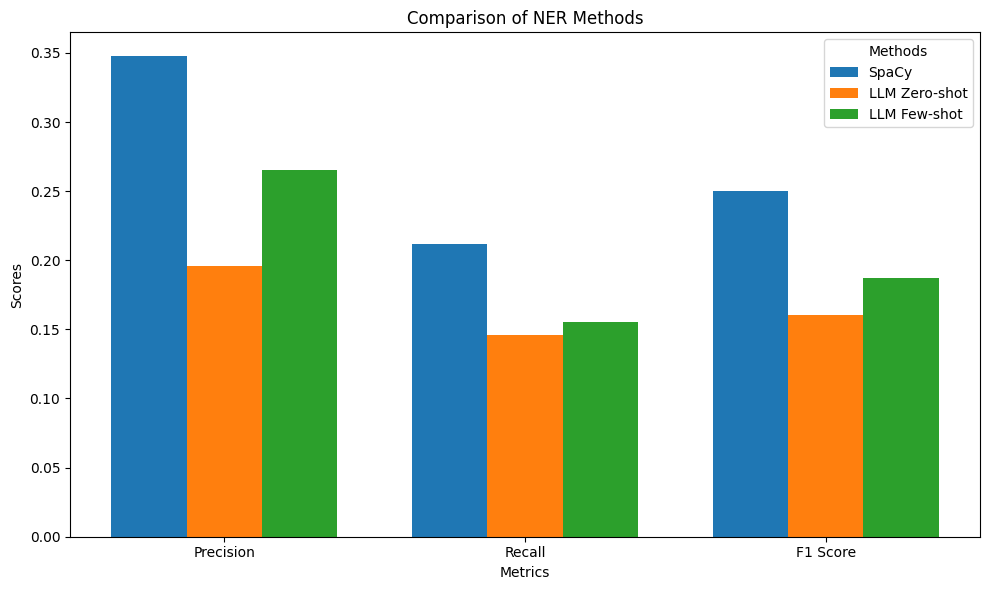

In [45]:
spacy_scores = [x / n for x in spacy_scores_total]
llm_zero_scores = [x / n for x in llm_zero_scores_total]
llm_few_scores = [x / n for x in llm_few_scores_total]

methods = ["SpaCy", "LLM Zero-shot", "LLM Few-shot"]
metrics = ["Precision", "Recall", "F1 Score"]
scores = [spacy_scores, llm_zero_scores, llm_few_scores]

x = np.arange(len(metrics))
width = 0.25

fig, ax = plt.subplots(figsize=(10, 6))

for i, method_scores in enumerate(scores):
    ax.bar(
        x + i * width,
        method_scores,
        width,
        label=methods[i]
    )

ax.set_xlabel("Metrics")
ax.set_ylabel("Scores")
ax.set_title("Comparison of NER Methods")
ax.set_xticks(x + width)
ax.set_xticklabels(metrics)
ax.legend(title="Methods")

plt.tight_layout()
plt.show()

The evaluation of SpaCy, LLM Zero-shot, and LLM Few-shot approaches for Named Entity Recognition (NER) highlights clear strengths and weaknesses. SpaCy performed consistently well, with high precision in many cases, but its recall was sometimes limited, as it missed entities in more complex or ambiguous scenarios. The Zero-shot LLM approach demonstrated flexibility, occasionally identifying entities SpaCy missed, but it was inconsistent, with low precision and recall in many cases. This method also struggled significantly with Polish text, particularly diacritical marks, leading to frequent errors.

The Few-shot LLM approach showed improvements over Zero-shot by using examples to provide better context, resulting in higher accuracy in complex cases. However, it still fell short of SpaCy in overall performance, particularly in handling multiple entities and language-specific nuances.

In summary, SpaCy proved to be the most reliable for structured and well-defined tasks, while Few-shot LLMs showed potential in more nuanced cases but require better handling of Polish-specific challenges. Zero-shot LLMs, while flexible, were too inconsistent to be effective for high-quality NER tasks. 

#### Questions (2 points):

**1. How does the performance of LLM-based NER compare to traditional approaches? What are the trade-offs in terms of accuracy, speed, and resource usage?**

LLM-based NER offers greater flexibility and adaptability to novel or complex scenarios compared to traditional approaches like SpaCy. However, it is less consistent and struggles with language-specific challenges, such as Polish diacritical marks. SpaCy delivers higher precision and recall in structured tasks, operates faster, and uses fewer computational resources. In contrast, LLMs, particularly Few-shot, are slower and resource-intensive but perform better in nuanced or less-defined contexts.

**2. Which prompting strategy proved most effective for NER and classification tasks? Why?**

The Few-shot prompting strategy was the most effective, as it provided the LLM with contextual examples, leading to improved accuracy and more consistent results compared to Zero-shot. Few-shot better guided the model in understanding task requirements, reducing errors and improving performance in complex scenarios.

**3. What are the limitations and potential biases of using LLMs for NER and classification?**

LLMs often struggle with language-specific nuances, such as diacritical marks, and may overgeneralize or misclassify entities. They can be biased by their pre-training data, leading to inaccurate predictions in underrepresented languages or domains. Additionally, they require substantial computational resources and are sensitive to poorly designed prompts, which can reduce their effectiveness.

**4. In what scenarios would you recommend using traditional NER vs. LLM-based approaches?**

Traditional NER, like SpaCy, is good for structured, well-defined tasks with standard entity types, where speed and reliability are priorities. LLM-based approaches are better suited for tasks involving complex, ambiguous, or novel entities and scenarios requiring greater contextual understanding, especially if computational resources and time are not primary constraints.

## Hints

1. Consider using prompt templates and systematic prompt engineering approaches
2. The quality of results heavily depends on the model size and prompt design
3. Consider implementing caching for LLM responses to speed up development
4. Pay attention to rate limits and resource usage when working with LLMs